In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from imblearn.over_sampling import SMOTE

In [2]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('credit_risk_dataset.csv')

# Data Analysis & and Preprocessing

In [4]:
df.shape

(32581, 12)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [ ]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [ ]:
df.isnull().sum()

,0
person_age,0
person_income,0
person_home_ownership,0
person_emp_length,895
loan_intent,0
loan_grade,0
loan_amnt,0
loan_int_rate,3116
loan_status,0
loan_percent_income,0


**Handling missing values**

In [5]:
df['person_emp_length'] = df['person_emp_length'].fillna(df['person_emp_length'].median())
df['loan_int_rate'] = df['loan_int_rate'].fillna(df['loan_int_rate'].median())

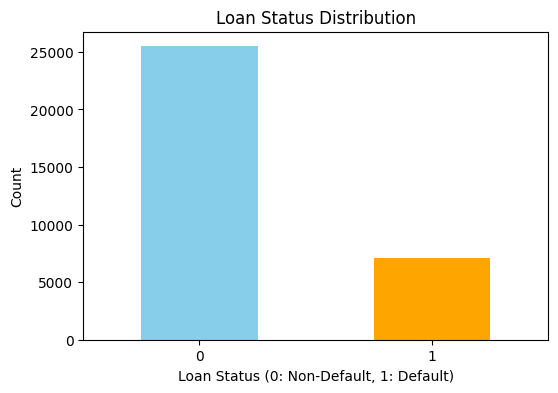

In [ ]:
# 1. Loan Status (out class) Distribution
# Approved:0
# Rejected:1

plt.figure(figsize=(6, 4))
df['loan_status'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Loan Status Distribution')
plt.xlabel('Loan Status (0: Non-Default, 1: Default)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

When previous_loan_defaults_on_file is Yes loan_status
0    3573
1    2172
Name: count, dtype: int64
When previous_loan_defaults_on_file is No loan_status
0    21900
1     4936
Name: count, dtype: int64


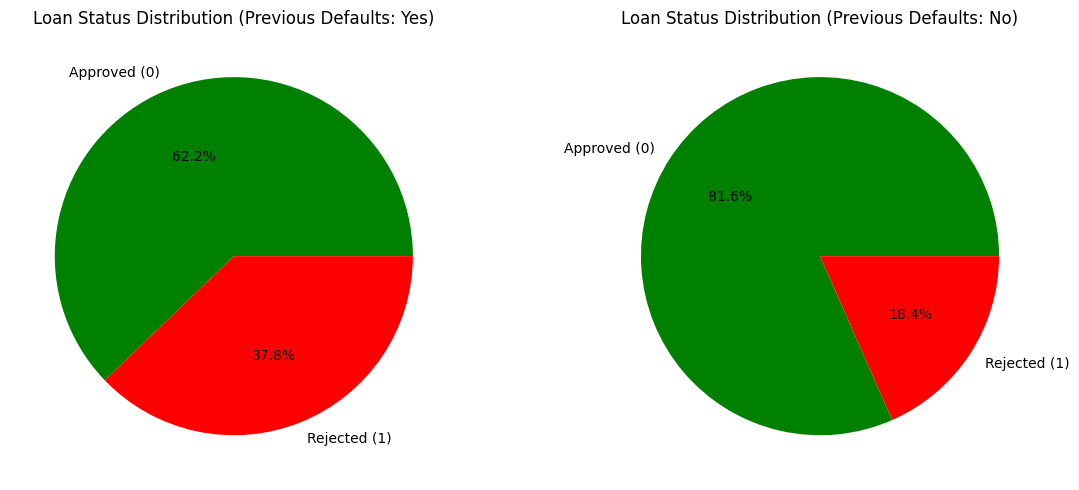

In [ ]:

# Case 1: When previous_loan_defaults_on_file is "Yes"
yes_data = df[df['cb_person_default_on_file'] == "Y"]['loan_status'].value_counts()
print("When previous_loan_defaults_on_file is Yes", yes_data)

# Case 2: When previous_loan_defaults_on_file is "No"
no_data = df[df['cb_person_default_on_file'] == "N"]['loan_status'].value_counts()
print("When previous_loan_defaults_on_file is No", no_data)

# Plotting Pie Charts
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Pie Chart for "Yes" Case
axes[0].pie(yes_data, labels=["Approved (0)", "Rejected (1)"], autopct='%1.1f%%', colors=['green', 'red'])
axes[0].set_title('Loan Status Distribution (Previous Defaults: Yes)')

# Pie Chart for "No" Case
axes[1].pie(no_data, labels=["Approved (0)", "Rejected (1)"], autopct='%1.1f%%', colors=['green', 'red'])
axes[1].set_title('Loan Status Distribution (Previous Defaults: No)')

# Show the plots
plt.tight_layout()
plt.show()

**Analysing the numerical features**



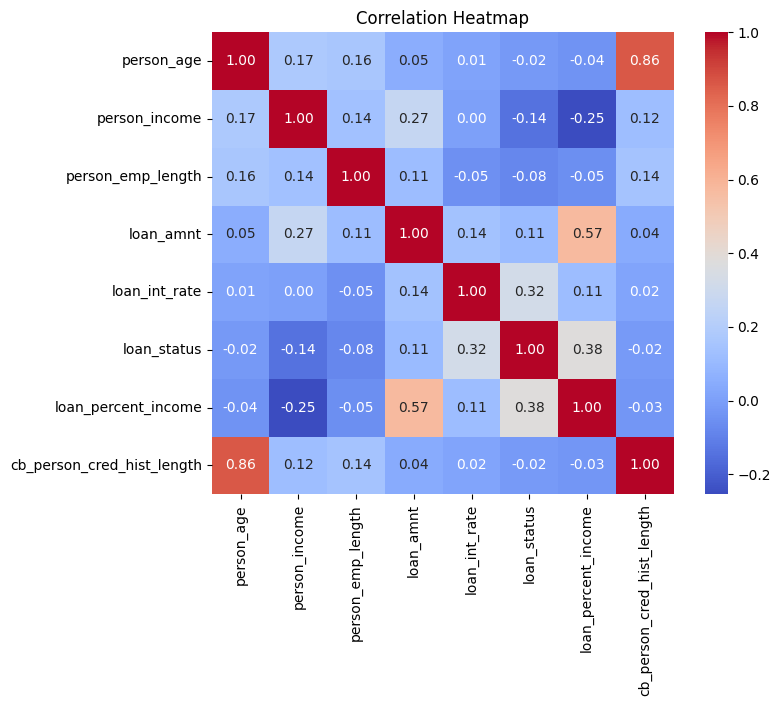

In [ ]:
#  Correlation Heatmap for Numerical Features

plt.figure(figsize=(8, 6))
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = df[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Heatmap')
plt.show()

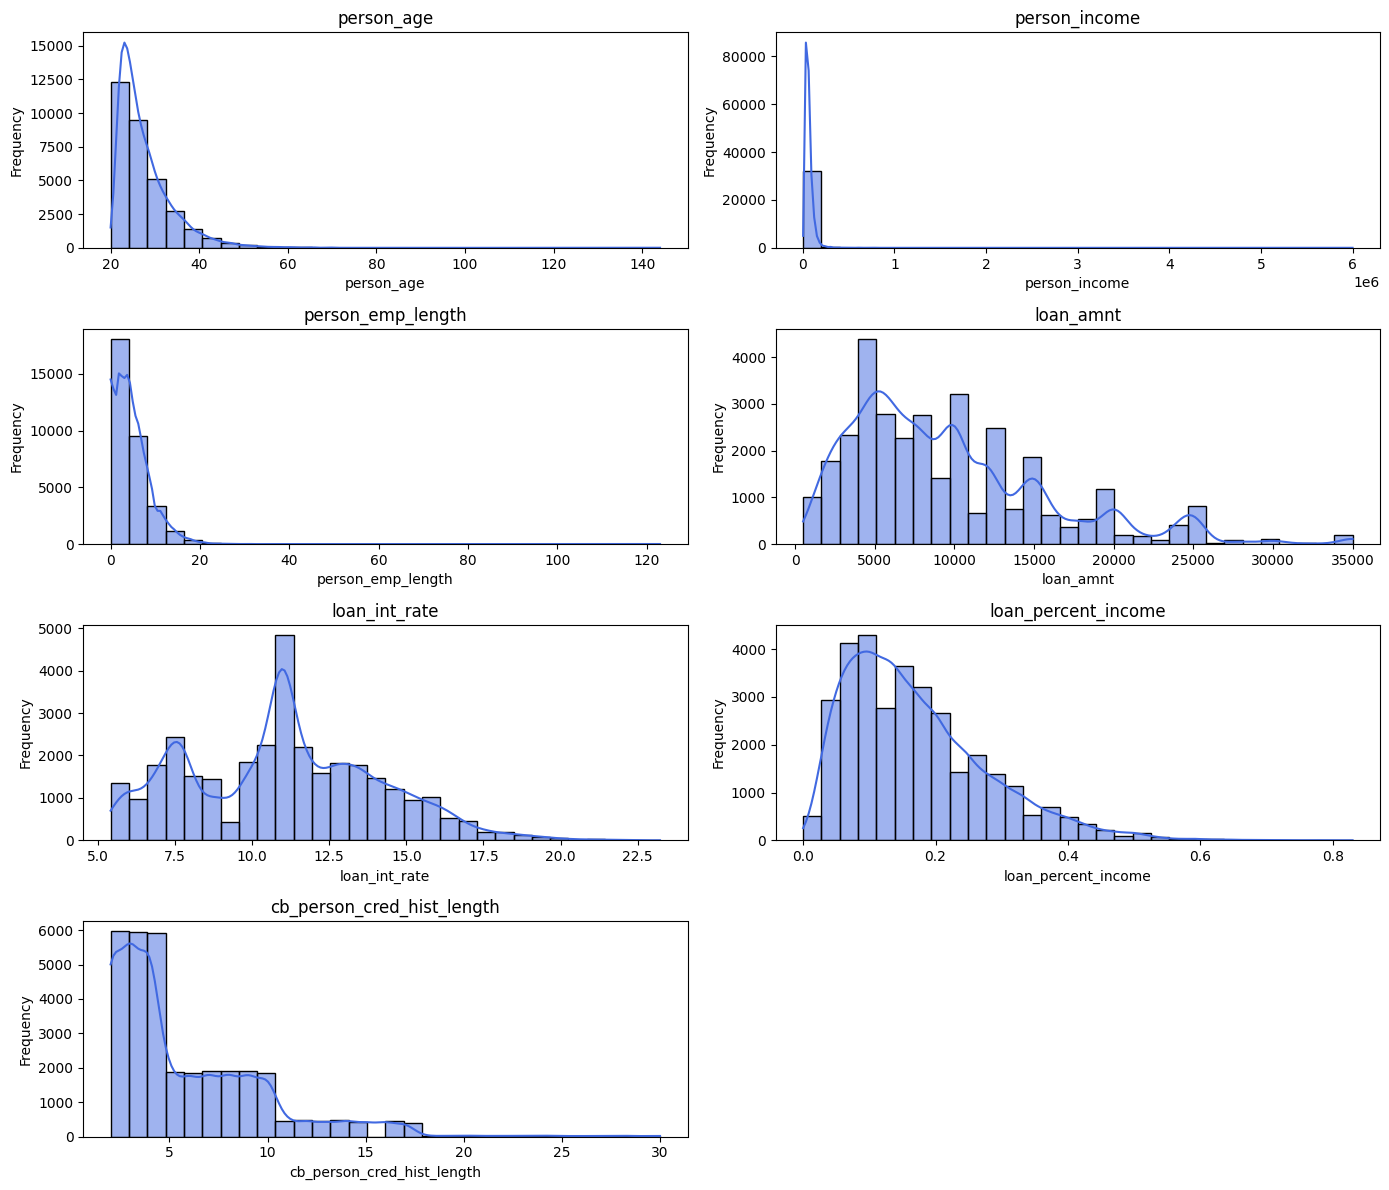

In [ ]:
numerical_cols = [
    "person_age", "person_income", "person_emp_length", "loan_amnt", "loan_int_rate",
    "loan_percent_income","cb_person_cred_hist_length",
]

# Set figure size for multiple plots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 12))
axes = axes.flatten()  # Flatten axes for easy iteration

# Plot histogram for each numerical column
for i, col in enumerate(numerical_cols):
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i], color="royalblue")
    axes[i].set_title(f"{col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

# Remove any empty subplots (if the number of features is odd)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for better visibility
plt.tight_layout()
plt.show()

**Analysing the categorical features**

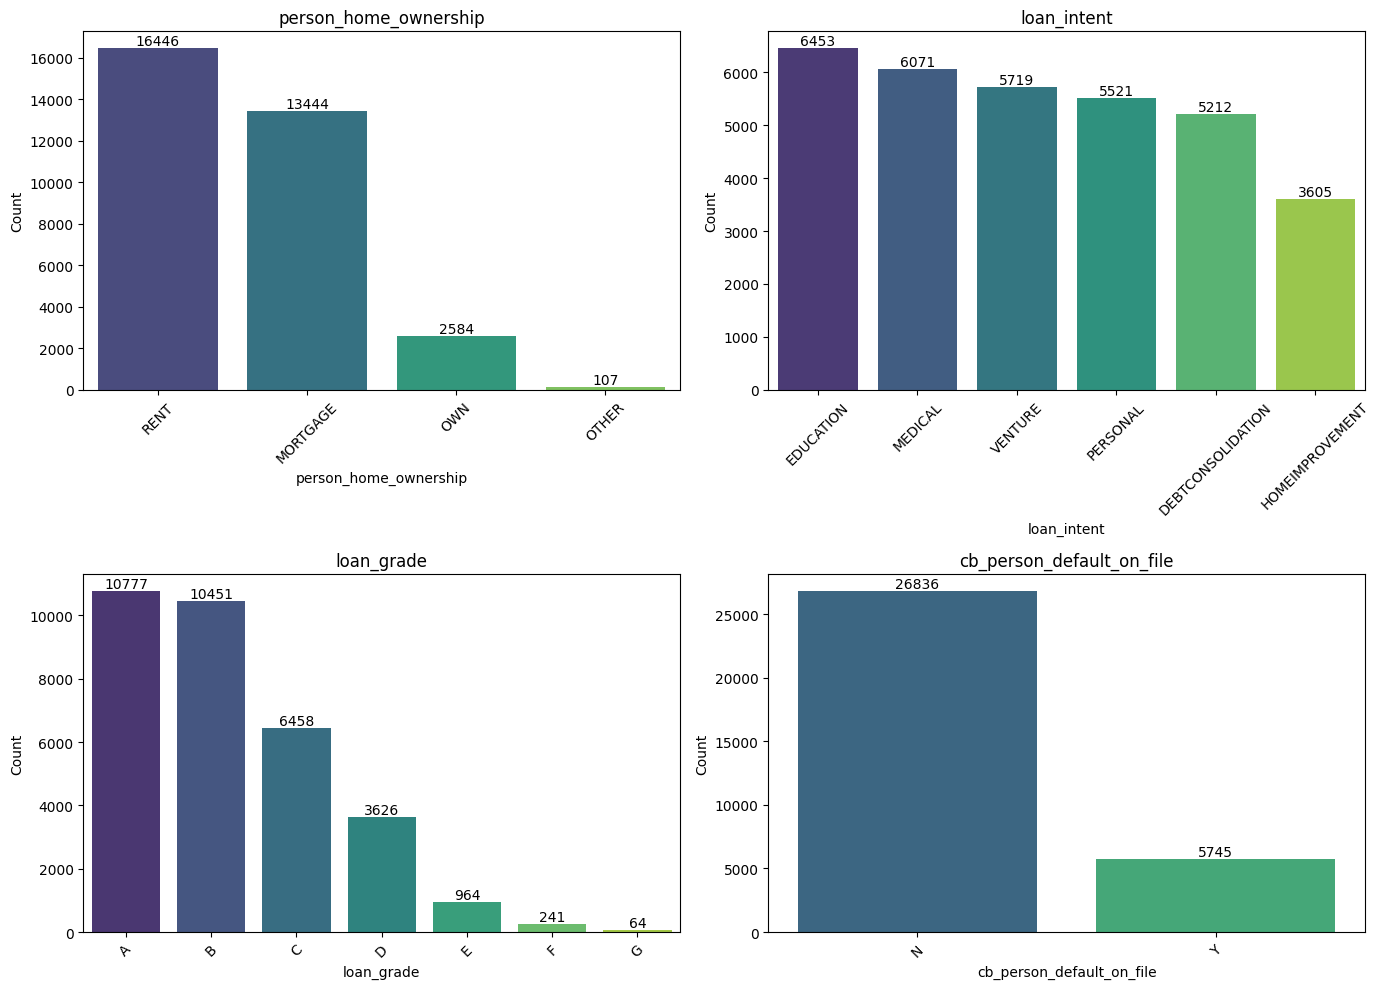

In [ ]:
categorical_cols = [ "person_home_ownership", "loan_intent", "loan_grade", "cb_person_default_on_file"]

fig, axes = plt.subplots(nrows=len(categorical_cols)//2, ncols=2, figsize=(14, 10))
axes = axes.flatten()

# Plot each categorical column
for i, col in enumerate(categorical_cols):
    value_counts = df[col].value_counts()

    sns.barplot(x=value_counts.index, y=value_counts.values, hue=value_counts.index, ax=axes[i], palette="viridis", legend=False)

    for p in axes[i].containers:
        axes[i].bar_label(p, fmt='%d', label_type='edge', fontsize=10)

    axes[i].set_title(f"{col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")

    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

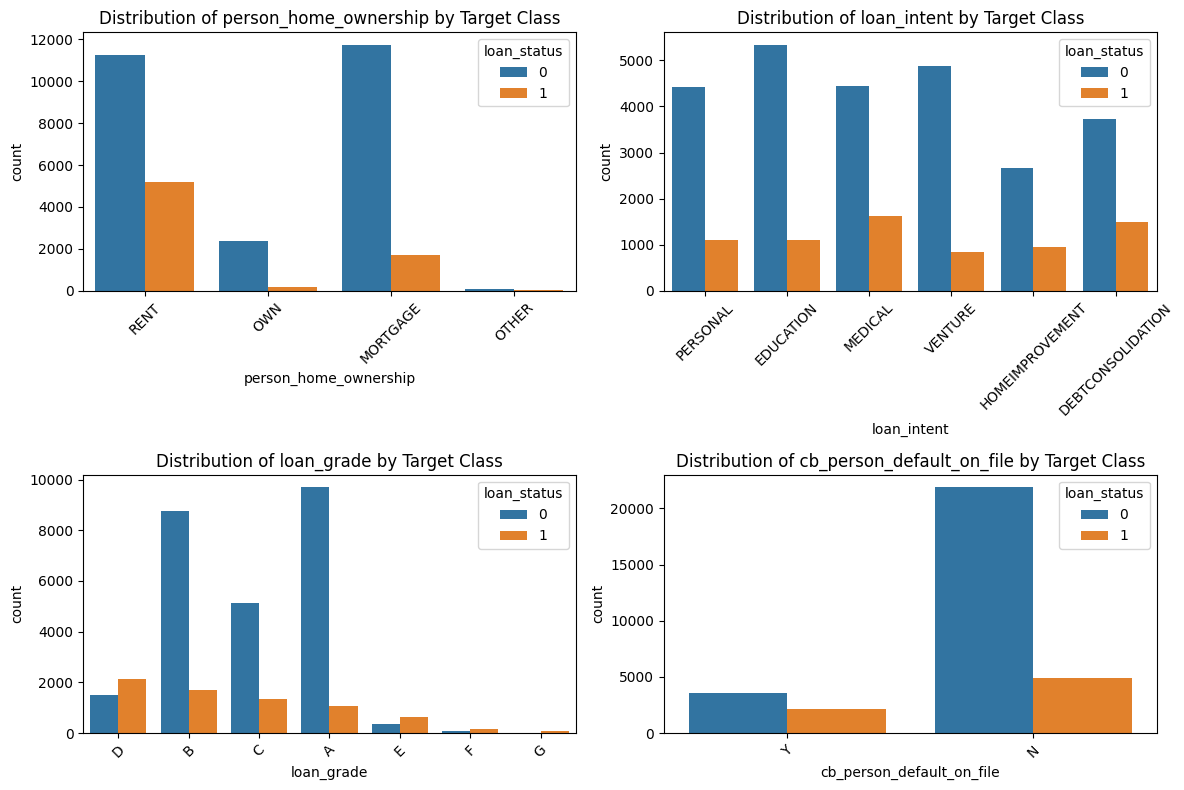

In [ ]:
# Selecting categorical columns
cat_features = df.select_dtypes(include=['object', 'category']).columns
num_features = len(cat_features)

# Define number of rows and columns for subplots
rows = (num_features // 2) + (num_features % 2)  # 2 columns per row
cols = 2

fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows))
axes = axes.flatten()

for i, col in enumerate(cat_features):
    sns.countplot(x=df[col], hue=df['loan_status'], data=df, ax=axes[i])
    axes[i].set_title(f'Distribution of {col} by Target Class')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

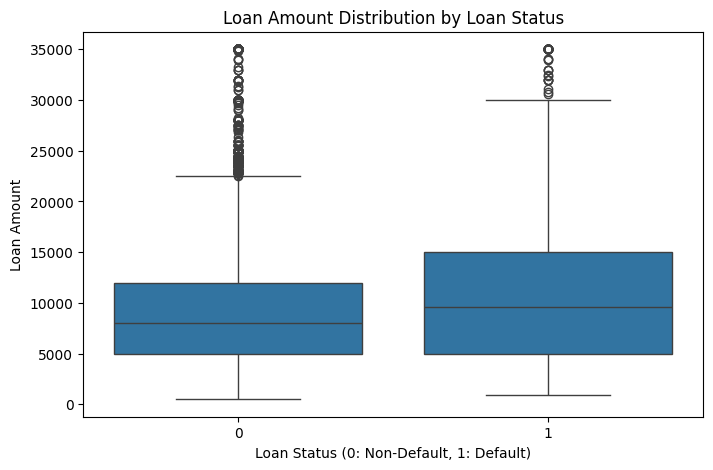

In [ ]:
# Boxplot without palette argument
plt.figure(figsize=(8, 5))
sns.boxplot(x='loan_status', y='loan_amnt', data=df)
plt.title('Loan Amount Distribution by Loan Status')
plt.xlabel('Loan Status (0: Non-Default, 1: Default)')
plt.ylabel('Loan Amount')
plt.show()


**Dealing with Outliers on numerical features**

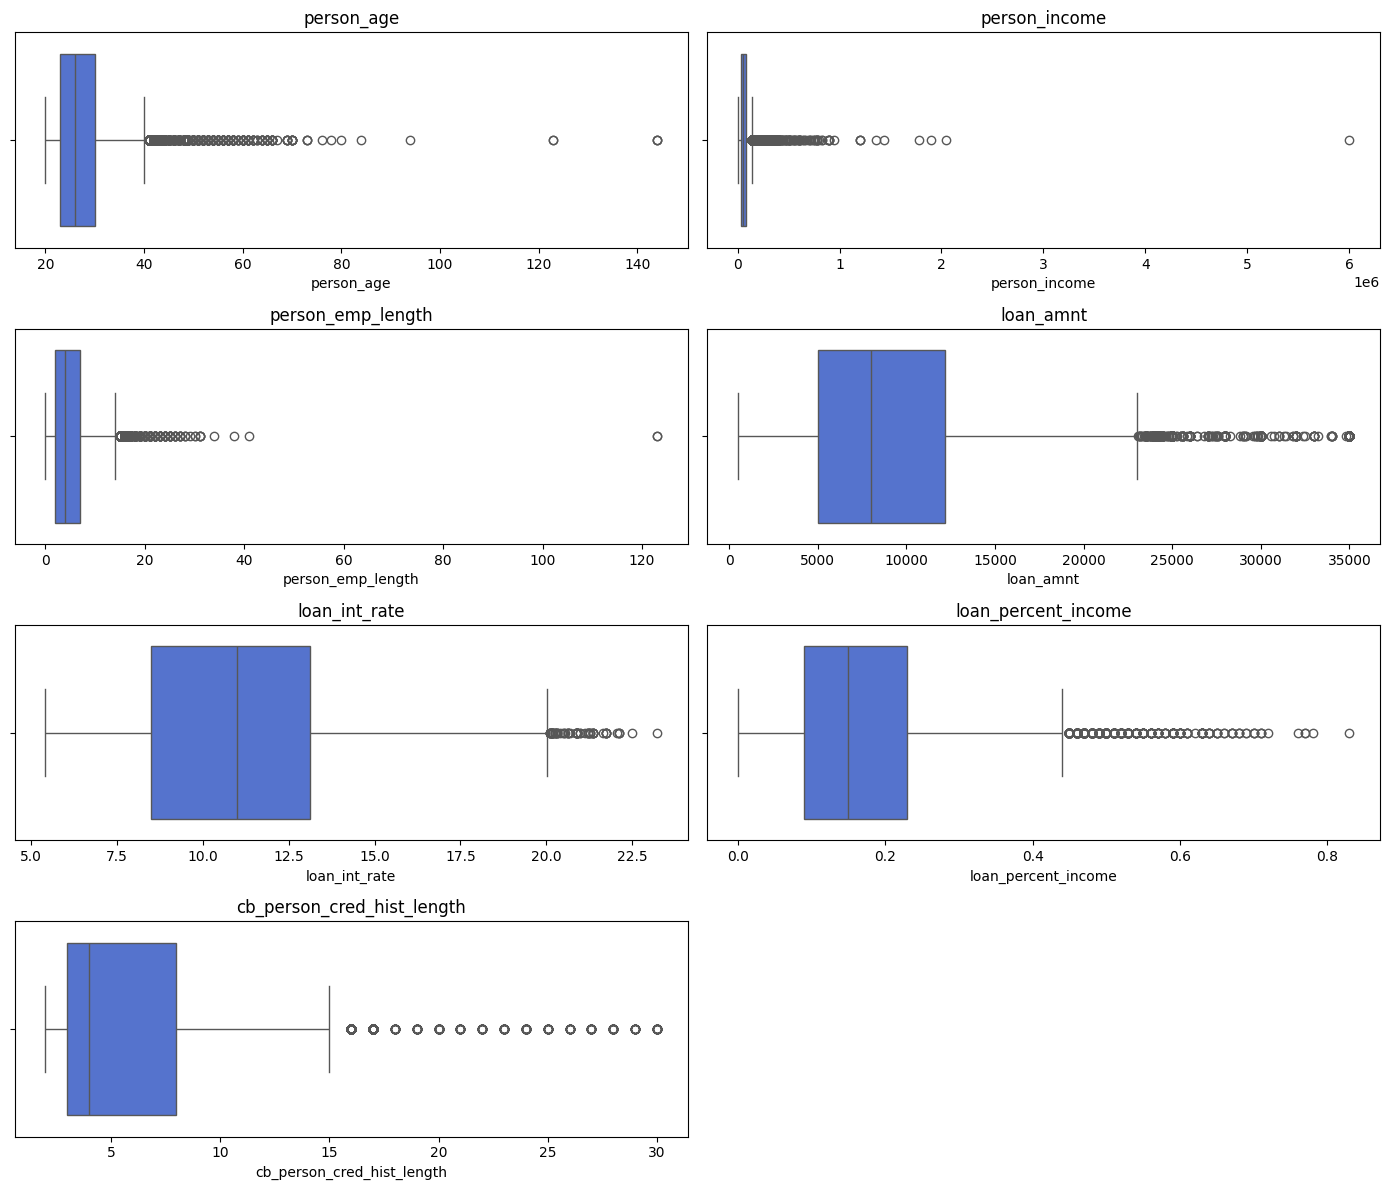

In [ ]:
# Set figure size for multiple plots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 12))
axes = axes.flatten()  # Flatten for easy iteration

# Create a box plot for each numerical column
for i, col in enumerate(numerical_cols):
    sns.boxplot(x=df[col], ax=axes[i], color="royalblue")
    axes[i].set_title(f"{col}")

# Remove any empty subplots (if the number of features is odd)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

**Anlysis on the above outlier boxplot**

- Person age :- Trimming samples where the person's age exceeds 85 is reasonable based on logical considerations. There are 6 such samples.
- Person annual Income :- A deeper analysis is required before making any modifications.
- Person employment length :- Trimming samples where the employment length exceeds 40 years is reasonable based on logical considerations. There are 3 such samples.
- Loan Amount :- No changes are required.
- Loan interest rate :- Although 74 samples exceed the boxplot's upper range of 20, their values are not significantly higher (around 22.5). Therefore, trimming is unnecessary.
- Loan percent income :- No changes are required.
- Past credit history length :- No changes are required.

In [6]:
age_threshold = 85
count_age_exceeding = (df['person_age'] > age_threshold).sum()

# Count samples exceeding employment length threshold
employment_threshold = 40
count_employment_exceeding = (df['person_emp_length'] > employment_threshold).sum()

# Apply trimming (removing these samples)
df = df[(df['person_age'] <= age_threshold) & (df['person_emp_length'] <= employment_threshold)]

# Print results
print(f"Trimming applied for Person Age > {age_threshold}: {count_age_exceeding} samples removed.")
print(f"Trimming applied for Employment Length > {employment_threshold}: {count_employment_exceeding} samples removed.")

Trimming applied for Person Age > 85: 6 samples removed.
Trimming applied for Employment Length > 40: 3 samples removed.


In [ ]:
#max and min income
max_ = df['person_income'].max()
min_ = df['person_income'].min()

print(f"maximum Income {max_}")
print(f"minimum Income {min_}")

#people with an income between x and y
def income_group(arr):
    lenarr = len(arr)
    for i in range(0,lenarr-1):
        next = arr[i]+1
        num_people = df['person_income'].between(next,arr[i+1]).sum()
        print(f'Income between {next} and {arr[i+1]}: Number of people {num_people}')

income_group([0, 25000, 50000, 75000, 100000,float('inf')])

maximum Income 6000000
minimum Income 4000
Income between 1 and 25000: Number of people 2469
Income between 25001 and 50000: Number of people 11613
Income between 50001 and 75000: Number of people 9622
Income between 75001 and 100000: Number of people 4670
Income between 100001 and inf: Number of people 4207


In [7]:
cap_value = np.percentile(df['person_income'], 95)
count_exceeding = (df['person_income'] > cap_value).sum()

# Apply capping at 99 percentile for person income feature
df['person_income'] = np.where(df['person_income'] > cap_value, cap_value, df['person_income'])

# Recalculate loan_percent_income after capping
df['loan_percent_income'] = df['loan_amnt'] / df['person_income']

print(f"Capping applied at: {cap_value}")
print(f"Number of samples exceeding the 99th percentile ({cap_value}): {count_exceeding}")

Capping applied at: 138000.0
Number of samples exceeding the 99th percentile (138000.0): 1613


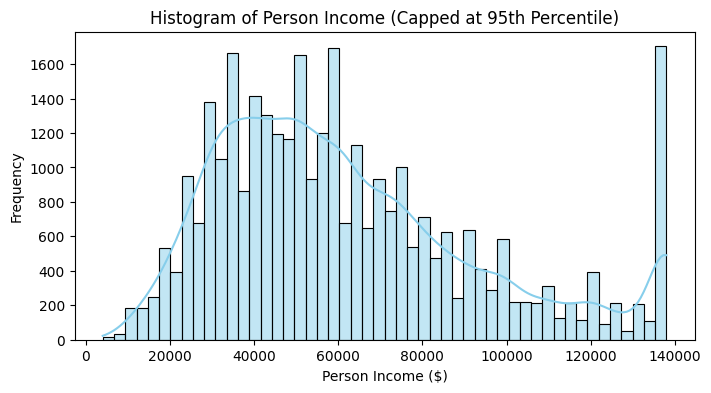

In [ ]:
plt.figure(figsize=(8, 4))
sns.histplot(df['person_income'], bins=50, kde=True, color="skyblue")
plt.xlabel("Person Income ($)")
plt.ylabel("Frequency")
plt.title("Histogram of Person Income (Capped at 95th Percentile)")
plt.show()

**One-Hot& Label encdoing for categorical features**
- ✅ One-Hot Encoding for:

 - person_home_ownership (Small number of categories, no ordinal relationship )

 - loan_intent (Represents intent (e.g., education, medical), no ranking)

- ✅ Label Encoding for:

  - loan_grade (ordinal ranking makes label encoding more meaningful)

  - cb_person_default_on_file (binary variable, label encoding is simpler)

In [ ]:
# Apply one hot encoding
ohe_cols = ['person_home_ownership', 'loan_intent']
df = pd.get_dummies(df, columns=ohe_cols)
df.loc[:, df.columns.str.startswith(tuple(ohe_cols))] = df.loc[:, df.columns.str.startswith(tuple(ohe_cols))].astype(int) # Boolean to int(0,1)

In [9]:
# Define mappings for label encoding
label_mappings = {
    'loan_grade': {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6},
    'cb_person_default_on_file': {'N': 0, 'Y': 1}
}

# Apply the mapping
for col, mapping in label_mappings.items():
    df[col] = df[col].map(mapping)

In [10]:
df.shape

(32572, 20)

In [ ]:
df.head()

,person_age,person_income,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE
1,21,9600.0,5.0,1,1000,11.14,0,0.104167,0,2,0,0,1,0,0,1,0,0,0,0
2,25,9600.0,1.0,2,5500,12.87,1,0.572917,0,3,1,0,0,0,0,0,0,1,0,0
3,23,65500.0,4.0,2,35000,15.23,1,0.534351,0,2,0,0,0,1,0,0,0,1,0,0
4,24,54400.0,8.0,2,35000,14.27,1,0.643382,1,4,0,0,0,1,0,0,0,1,0,0
5,21,9900.0,2.0,0,2500,7.14,1,0.252525,0,2,0,0,1,0,0,0,0,0,0,1


**Feature importance Tests**

In [ ]:
# Feature selection using information gain

X_check = df.drop(columns=['loan_status'])
y_check = df['loan_status']

info_gain = mutual_info_classif(X_check, y_check)

In [ ]:
# Create DataFrame to view scores
feature_importance = pd.DataFrame({'Feature': X_check.columns, 'Information Gain': info_gain})
feature_importance = feature_importance.sort_values(by='Information Gain', ascending=False)

# Print the Information Gain scores
print(feature_importance)

                           Feature  Information Gain
6              loan_percent_income          0.109127
1                    person_income          0.104578
3                       loan_grade          0.075300
5                    loan_int_rate          0.067355
12      person_home_ownership_RENT          0.032870
9   person_home_ownership_MORTGAGE          0.021719
7        cb_person_default_on_file          0.015245
4                        loan_amnt          0.012397
2                person_emp_length          0.008809
11       person_home_ownership_OWN          0.006321
13   loan_intent_DEBTCONSOLIDATION          0.004865
18             loan_intent_VENTURE          0.003918
14           loan_intent_EDUCATION          0.003825
8       cb_person_cred_hist_length          0.000964
16             loan_intent_MEDICAL          0.000784
17            loan_intent_PERSONAL          0.000518
0                       person_age          0.000000
10     person_home_ownership_OTHER          0.

# Model Training

In [11]:
X = df.drop(columns=['loan_status'])
y = df['loan_status']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Applying different ML Models

models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric="logloss", random_state=42),
    "CatBoost": CatBoostClassifier(iterations=200, verbose=0, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
}

# Train and evaluate models
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results.append([name, accuracy, precision, recall, f1])

# Convert results into a DataFrame
columns = ["Model", "Accuracy", "Precision", "Recall", "F1 Score"]
df_results = pd.DataFrame(results, columns=columns).sort_values(by="Accuracy", ascending=False)

print("\nModel Performance:\n", df_results)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:32:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Model Performance:
                  Model  Accuracy  Precision    Recall  F1 Score
5        Random Forest  0.940138   0.979648  0.742116  0.844498
4             CatBoost  0.939678   0.968297  0.749124  0.844725
3              XGBoost  0.937068   0.951198  0.751226  0.839468
0        Decision Tree  0.897928   0.753324  0.793973  0.773115
2             AdaBoost  0.884421   0.788527  0.645410  0.709827
1  Logistic Regression  0.840215   0.708423  0.459706  0.557586


**Applying SMOTE on only the category 2**

In [14]:

# First, concatenate X_train and y_train for easier filtering
train_df = pd.concat([X_train, y_train], axis=1)

# Separate Category 1 and Category 2 based on 'previous_loan_defaults_on_file'
cat1 = train_df[train_df['cb_person_default_on_file'] == 1]
cat2 = train_df[train_df['cb_person_default_on_file'] == 0]

# Split features and target for Cat 2
X_cat2 = cat2.drop('loan_status', axis=1)
y_cat2 = cat2['loan_status']

# Apply SMOTE only on Cat 2
smote = SMOTE(random_state=42)
X_cat2_resampled, y_cat2_resampled = smote.fit_resample(X_cat2, y_cat2)

# Reconstruct resampled DataFrame for Cat 2
cat2_resampled = pd.concat([pd.DataFrame(X_cat2_resampled, columns=X_cat2.columns),
                            pd.Series(y_cat2_resampled, name='loan_status')], axis=1)

# Final train set = Original Cat 1 (untouched) + Resampled Cat 2
train_df_resampled = pd.concat([cat1, cat2_resampled], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)

# Separate final X_train and y_train
X_train_final = train_df_resampled.drop('loan_status', axis=1)
y_train_final = train_df_resampled['loan_status']


In [15]:
# Applying different ML Models

models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric="logloss", random_state=42),
    "CatBoost": CatBoostClassifier(iterations=200, verbose=0, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
}

# Train and evaluate models
results = []

for name, model in models.items():
    model.fit(X_train_final, y_train_final)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results.append([name, accuracy, precision, recall, f1])

# Convert results into a DataFrame
columns = ["Model", "Accuracy", "Precision", "Recall", "F1 Score"]
df_results = pd.DataFrame(results, columns=columns).sort_values(by="Accuracy", ascending=False)

print("\nModel Performance:\n", df_results)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:33:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Model Performance:
                  Model  Accuracy  Precision    Recall  F1 Score
4             CatBoost  0.939985   0.965827  0.752628  0.846002
3              XGBoost  0.936761   0.938634  0.761037  0.840557
5        Random Forest  0.936454   0.952636  0.747022  0.837392
0        Decision Tree  0.885802   0.719614  0.784163  0.750503
2             AdaBoost  0.870913   0.700960  0.716188  0.708492
1  Logistic Regression  0.804144   0.557943  0.509460  0.532601


In [16]:
# Train XGBoost model
model = XGBClassifier(n_estimators=100, eval_metric="logloss", random_state=42)
model.fit(X_train_final, y_train_final)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [17]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Model: XgBoost Model")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}\n")

Model: XgBoost Model
Accuracy: 0.9368
Precision: 0.9386
Recall: 0.7610
F1 Score: 0.8406



In [ ]:

def preprocess_input(input_data):

  ohe_cols = [
      "person_home_ownership_MORTGAGE", "person_home_ownership_OTHER",
      "person_home_ownership_OWN", "person_home_ownership_RENT",
      "loan_intent_DEBTCONSOLIDATION", "loan_intent_EDUCATION",
      "loan_intent_HOMEIMPROVEMENT", "loan_intent_MEDICAL",
      "loan_intent_PERSONAL", "loan_intent_VENTURE"
  ]

  input_df = pd.DataFrame([input_data])

  # Drop original categorical columns (since we use one-hot encoding)
  input_df.drop(columns=["person_home_ownership", "loan_intent"], inplace=True, errors="ignore")

  # Add one-hot encoded columns and set the correct value
  for col in ohe_cols:
      input_df[col] = 0

  # Set the correct one-hot encoded column to 1 based on input data
  if f"person_home_ownership_{input_data['person_home_ownership']}" in ohe_cols:
      input_df[f"person_home_ownership_{input_data['person_home_ownership']}"] = 1

  if f"loan_intent_{input_data['loan_intent']}" in ohe_cols:
      input_df[f"loan_intent_{input_data['loan_intent']}"] = 1

  return input_df

def predict(self, input_data):
  processed_input = self.preprocess_input(input_data)
  prediction = self.model.predict(processed_input)
  return "Rejected" if prediction[0] == 1 else "Approved"

In [ ]:
import pickle

In [ ]:
# Save the pipeline as a pickle file
with open("loan_xgboost4.pkl", "wb") as f:
    pickle.dump(model, f)

print("✅ Model pipeline saved as loan_xgboost4.pkl")

✅ Model pipeline saved as loan_xgboost4.pkl


In [ ]:
# Load the saved model pipeline
with open("loan_xgboost4.pkl", "rb") as f:
    loan_pipeline = pickle.load(f)

# Sample input
input_data = {
    "person_age": 30,
    "person_income": 50000,
    "person_emp_length": 2,
    "loan_grade": 0,
    "loan_amnt": 4000,
    "loan_int_rate": 20.5,
    "loan_percent_income": None,
    "cb_person_default_on_file": 0,
    "cb_person_cred_hist_length": 5,
    "person_home_ownership": "RENT",
    "loan_intent": "EDUCATION"
}

input_data["loan_percent_income"] = input_data["loan_amnt"] / input_data["person_income"]

# Predict
prediction = loan_pipeline.predict(input_data)
print("🔹 Loan Approval Prediction: ", prediction)